In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
import os
from utils import * # Code shared across more than one notebook

# gVirtualXRay CT acquisition vs chest phantom CT data

**Outline:**
This notebook demonstrates the use of gVirtualXRay in a CT medical application. For this experiment, we attempt to recreate a real CT acquisition of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate CT acquisition on this model and 
5. compare the result with the reference CT. 

An advantage of some experiments in this notebook is that a significant number of samples ($512 \times 512 \times 426$) are used in comparisons. A concern is that the quality of the virtual chest phantom, used as the gVirtualXRay sample, is solely dependent on manual segmentation giving additional error to X-Ray data outside of gVirtualXRay's responsibility.  

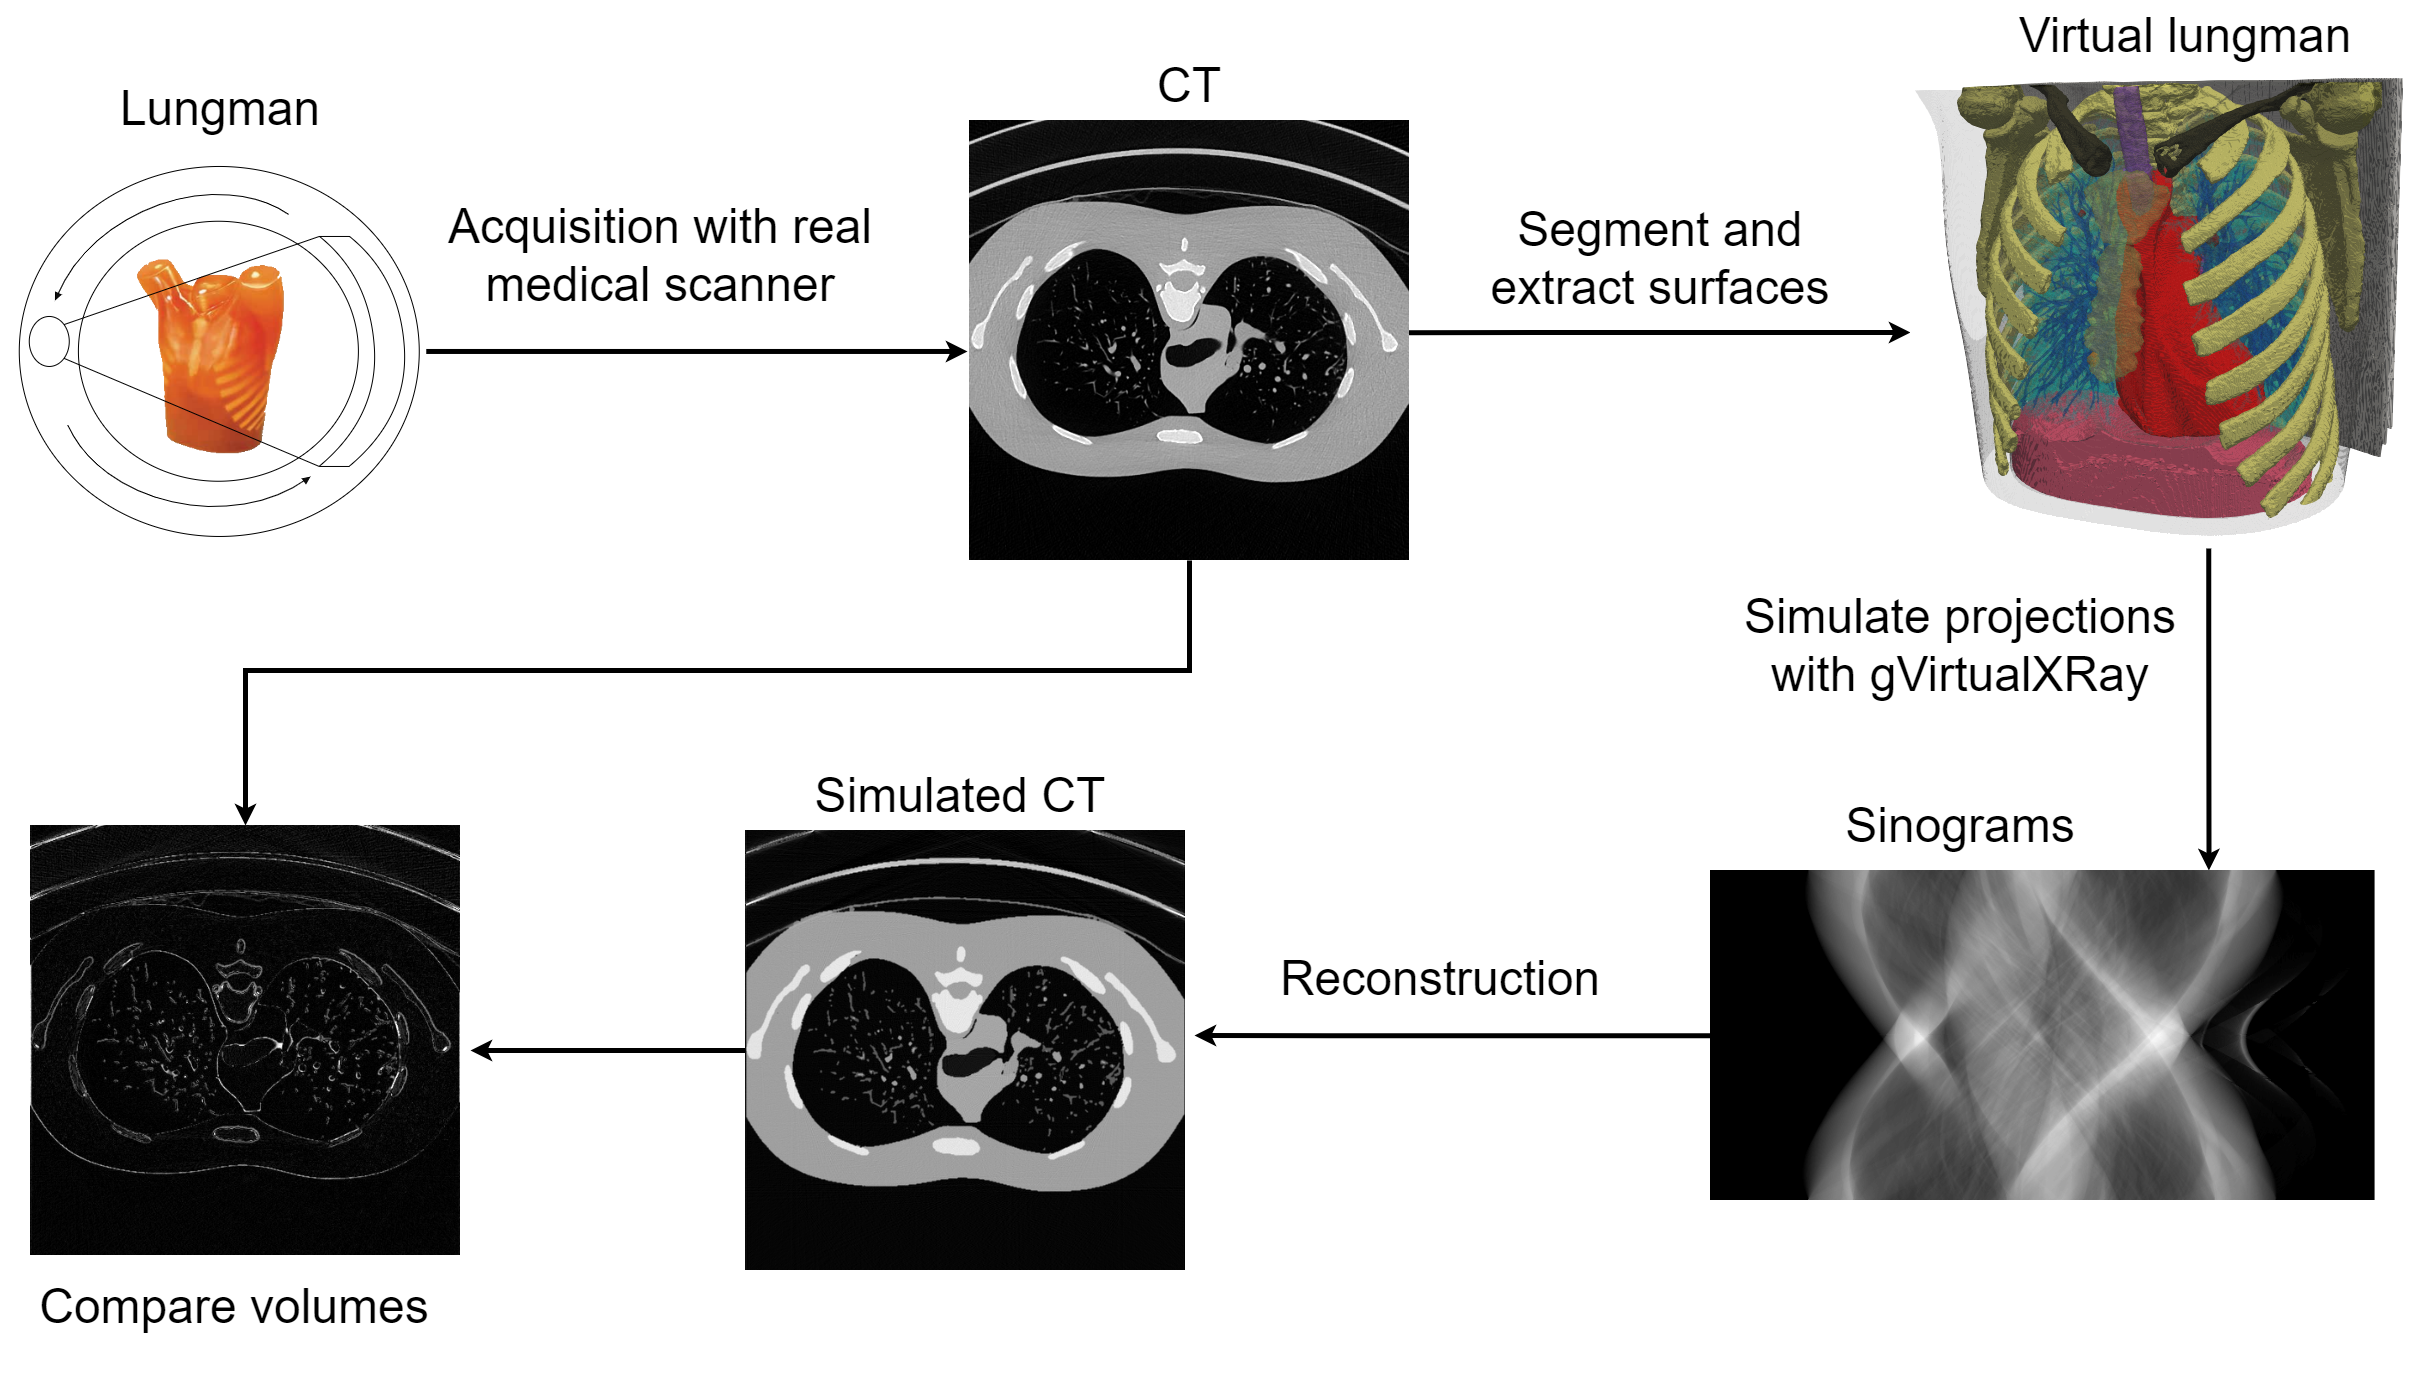

In [2]:
Image("../doc/gvxrflow.drawio.png", width=800)

**Methods and materials:** The setup for gVirtualXRay involved a sample centered about the origin, placing the source 500mm away from the object (SOD) and the detector also 500mm away (SDD). \
The beam is monochromatic with photons having 72keV of energy. A parallel beam is used in this experiment for simplicity because recovering the parameters from the original acquisition with the medical scanner would be difficult. \
The detector is set-up to best match the reference CT accounting for pixel size, resulting in the detector being approximately 453mm wide and 298mm tall. A width of 725 ($512 \times \sqrt{2}$) pixels is used instead of the 512 pixels found in the reference CT so the inscribed circle can be removed during the reconstruction process.

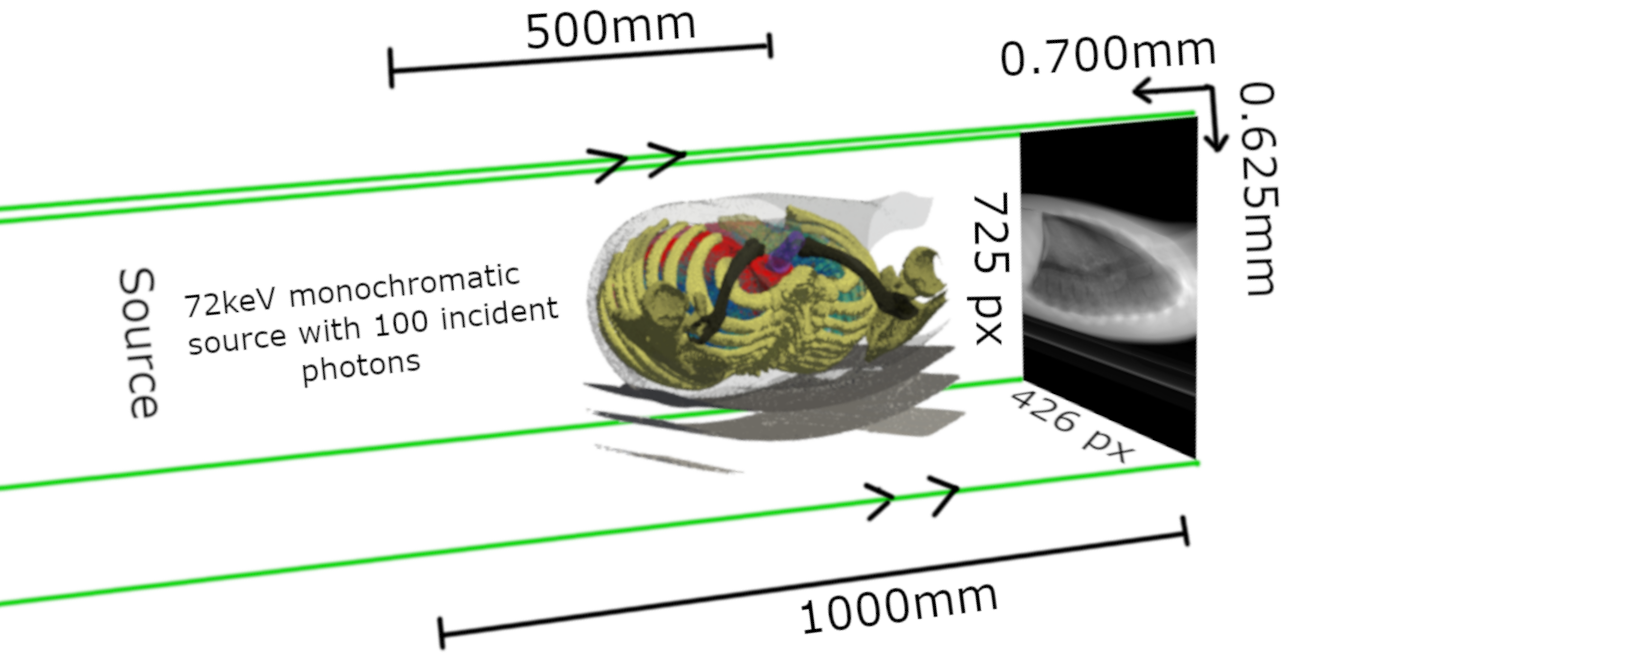

In [3]:
Image("../doc/gvxr-lungman-environment.png", width=800)

In [4]:
#with open('../doc/chest-paraview.gif','rb') as f:
#   display(Image(data=f.read(), format='png', width=480))

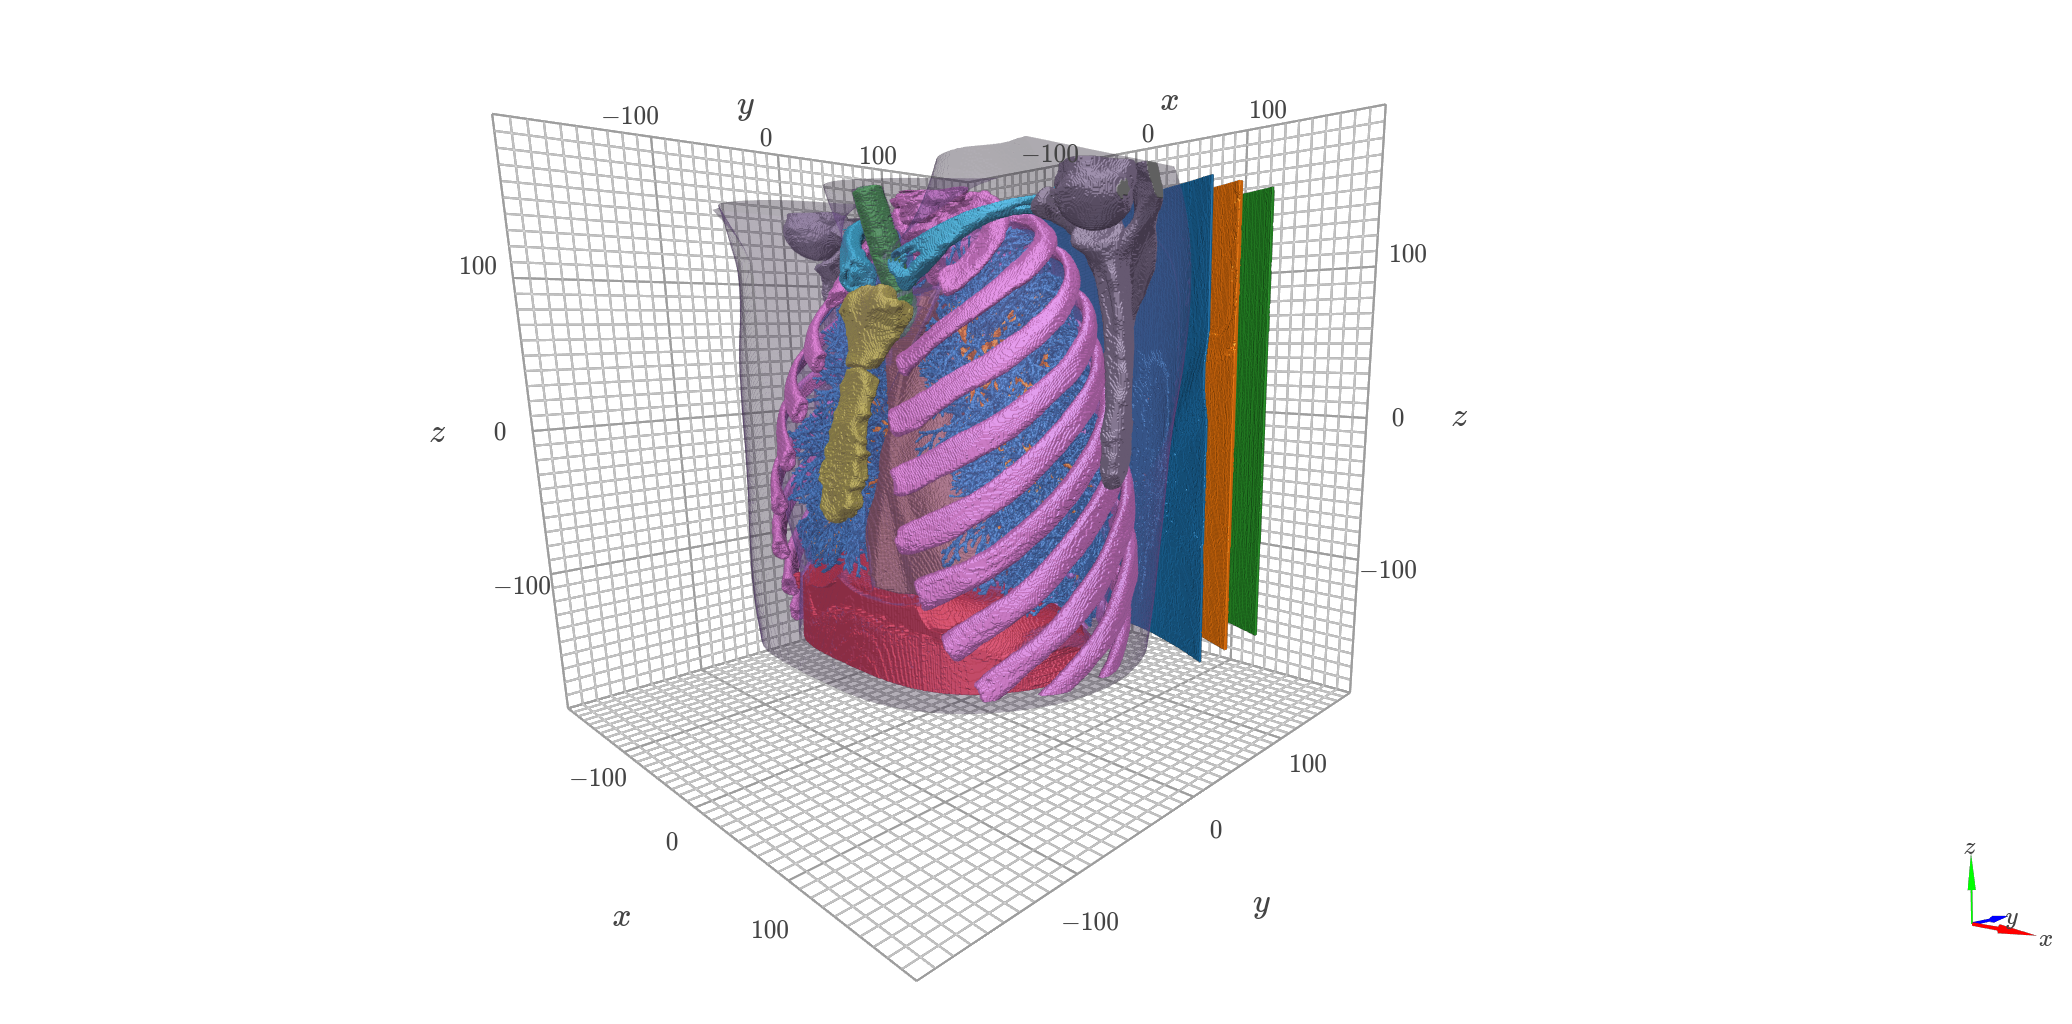

In [5]:
fname = "./plots/lungman_model.png"
if os.path.exists(fname):
    display(Image(fname))

# Results

**Diagonal plot comparison**\
These two plots are sampled from the diagonal pixels of slice 150 from both the ground truth CT and simulated CT of the chest phantom.\
<span style="color:green">Green</span>: Ground truth CT plot\
<span style="color:red">Red</span>: Simulated CT plot\
This experiment proves the most significant changes in attenuation are accurately simulated. The simulated CT appears less noisy presumably because our experiment does not account for the natural deviation of image quality that comes with real equipment.

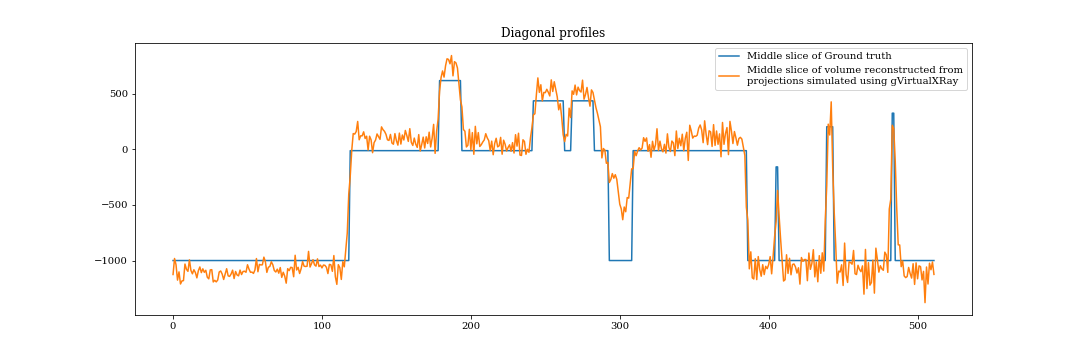

In [6]:
fname = "./plots/lungman-profiles-CT.png"
if os.path.exists(fname):
    display(Image(fname))

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

The calculations were performed on the following platform:

In [7]:
printSystemInfo()

OS:
	Linux 5.3.18-150300.59.49-default
	x86_64

CPU:
 	AMD Ryzen 7 3800XT 8-Core Processor

RAM:
	63 GB
GPU:
	Name: GeForce RTX 2080 Ti
	Drivers: 455.45.01
	Video memory: 11 GB


# Import packages

In [8]:
tomography_backend = "scikit-image"
tomography_backend = "tigre"
tomography_backend = "tomopy"

In [9]:
%matplotlib inline

import SimpleITK as sitk
import pandas as pd
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'serif'#,
        #'weight' : 'bold',
         # 'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imsave # Load/Write TIFF file

if tomography_backend == "tomopy":
    import tomopy
elif tomography_backend == "tigre":
    import tigre
    import tigre.algorithms as algs
    import tomopy
elif tomography_backend == "scikit-image":
    from skimage.transform import iradon
    from skimage.transform import radon
else:
    IOError("No tomography reconstruction backend")

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
#import scipy
import os
import math
import zipfile
import datetime

import imageio

import k3d
import random
import base64
from stl import mesh
from time import sleep

SimpleGVXR 1.0.1 (2022-01-18T20:08:45) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-01-18T20:08:25) [Compiler: GNU g++] on Linux


# Performance
* The number of threads chosen will largely dictate the speed of reconstruction.
* The number of projections will affect the quality of the reconstruction.
* Artefact filtering, as you can expect, provides better quality image at the expense of speed.
* Artefact filtering on the GPU gives a decent compromise of speed to quality.

In [10]:
ray_energy = 72
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False

number_of_projections = 181
# span = 180
span = 360
angular_step = span / number_of_projections;
theta_deg = np.linspace(0.0, angular_step * number_of_projections, num=number_of_projections, endpoint=False)

In [11]:
print("Number of projections:", theta_deg.shape[0])
print("Angle between successive projections:", angular_step)
print("First angle:", theta_deg[0])
print("Last angle:", theta_deg[-1])

Number of projections: 181
Angle between successive projections: 1.988950276243094
First angle: 0.0
Last angle: 358.0110497237569


In [12]:
print(theta_deg)

[  0.           1.98895028   3.97790055   5.96685083   7.9558011
   9.94475138  11.93370166  13.92265193  15.91160221  17.90055249
  19.88950276  21.87845304  23.86740331  25.85635359  27.84530387
  29.83425414  31.82320442  33.8121547   35.80110497  37.79005525
  39.77900552  41.7679558   43.75690608  45.74585635  47.73480663
  49.72375691  51.71270718  53.70165746  55.69060773  57.67955801
  59.66850829  61.65745856  63.64640884  65.63535912  67.62430939
  69.61325967  71.60220994  73.59116022  75.5801105   77.56906077
  79.55801105  81.54696133  83.5359116   85.52486188  87.51381215
  89.50276243  91.49171271  93.48066298  95.46961326  97.45856354
  99.44751381 101.43646409 103.42541436 105.41436464 107.40331492
 109.39226519 111.38121547 113.37016575 115.35911602 117.3480663
 119.33701657 121.32596685 123.31491713 125.3038674  127.29281768
 129.28176796 131.27071823 133.25966851 135.24861878 137.23756906
 139.22651934 141.21546961 143.20441989 145.19337017 147.18232044
 149.1712707

# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [13]:
json2gvxr.initGVXR("notebook-11.json", "OPENGL");

Create an OpenGL context: 512x512
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 455.45.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 512 512


**Create a parallel photon beam.**

In [14]:
json2gvxr.initSourceGeometry();
gvxr.setMonoChromatic(ray_energy, "keV", 100);
gvxr.useParallelBeam();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [15]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']
INIT RENDER


In [16]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Load the ground truth

In [18]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha")
raw_ground_truth = sitk_reader.Execute()
real_CT_in_HU = np.array(sitk.GetArrayFromImage(raw_ground_truth));

#
# Blur using CurvatureFlowImageFilter
#
# blurFilter = sitk.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# sitk_ground_truth_CT_recons_in_HU = blurFilter.Execute(raw_ground_truth)
# ground_truth_CT_recons_in_HU = np.array(sitk.GetArrayFromImage(sitk_ground_truth_CT_recons_in_HU));

# Make sure each volume has floating point precision
real_CT_in_HU = real_CT_in_HU.astype(np.single);

# Drop the first and last slices
# ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU[1:ground_truth_CT_recons_in_HU.shape[0] - 1]

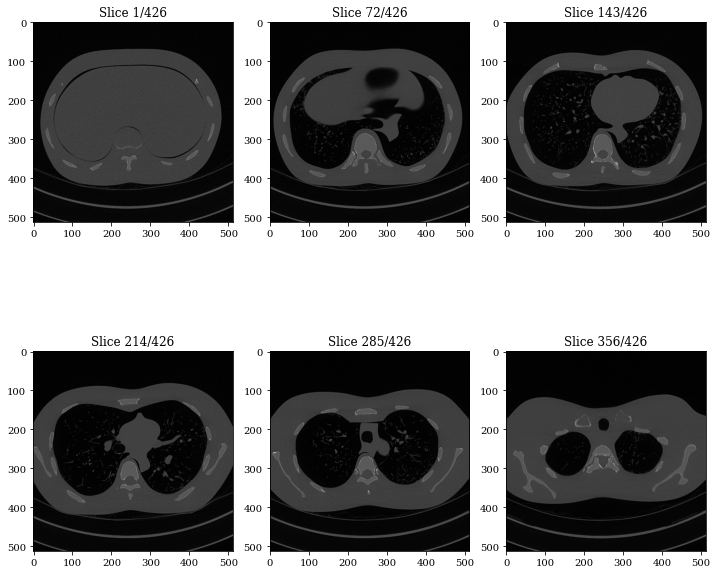

In [23]:
ncols = 3
nrows = 2

step = int(real_CT_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(real_CT_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(real_CT_in_HU.shape[0]))
        ax.imshow(real_CT_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-real_CT_in_HU.pdf')
plt.savefig('plots/lungman-real_CT_in_HU.png')

# Convert ground truth from HU to &mu;

In [24]:
fname = "gVirtualXRay_output_data/lungman-real_CT_in_mu.mha"

if not os.path.exists(fname):

    real_CT_in_mu = np.array(gvxr.convertHU2mu(real_CT_in_HU, ray_energy, "keV"))

    sitk_real_CT_in_mu = sitk.GetImageFromArray(real_CT_in_mu)
    sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_real_CT_in_mu.SetOrigin((-pixel_width * real_CT_in_mu.shape[2] / 2.0,
                          -pixel_width * real_CT_in_mu.shape[1] / 2.0,
                          -pixel_height * real_CT_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_real_CT_in_mu, fname, useCompression=True)

else:
    sitk_real_CT_in_mu = sitk.ReadImage(fname)
    real_CT_in_mu = sitk.GetArrayFromImage(sitk_image)

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [25]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
phantom = sitk.ReadImage(label_rel_path)
phantom_array = sitk.GetArrayFromImage(phantom)

In [27]:
# rd = vtk.vtkMetaImageReader();
# rd.SetFileName(label_rel_path);
# rd.Update()
# vtkLabels = rd.GetOutput();

# Create threshold filter
# threshold = vtk.vtkImageThreshold();
# threshold.SetInputData(vtkLabels);
# threshold.SetReplaceOut(0);
# threshold.ReplaceOutOn()
# threshold.ReplaceInOff();

fname_HU = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_HU.mha"
fname_mu = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_mu.mha"

ref_data = {}

if not os.path.exists(fname_HU) and not os.path.exists(fname_mu):
    digital_phatom_in_HU = np.zeros(phantom_array.shape, dtype=np.int16) - 1000
    digital_phatom_in_mu = np.zeros(phantom_array.shape, dtype=np.single)
else:
    sitk_digital_phatom_in_HU = sitk.ReadImage(fname_HU)
    digital_phatom_in_HU = sitk.GetArrayFromImage(sitk_digital_phatom_in_HU)

    sitk_digital_phatom_in_mu = sitk.ReadImage(fname_mu)
    digital_phatom_in_mu = sitk.GetArrayFromImage(sitk_digital_phatom_in_mu)    
    
    
for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    structure_name = tuple_parts[2][0:-4]
    structure_isovalue = int(tuple_parts[0])

    print("Process", structure_name)
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    # if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
#     threshold.ThresholdBetween(structure_isovalue, structure_isovalue);
#     threshold.Update();
#     vtkIm = threshold.GetOutput();
    
#     # Extract surface and save
#     vtkSurface = extractSurface(vtkIm, structure_isovalue);
#     writeSTL(vtkSurface, stl_rel_path);
#     vtkSurface = None;
#     vtkIm = None;    

    # Threshold the phantom
    binary_mask = (phantom == structure_isovalue)
    
    # Pad the image
    filt = sitk.ConstantPadImageFilter()
    filt.SetConstant (0)
    filt.SetPadLowerBound ([1, 1, 1])
    filt.SetPadUpperBound ([1, 1, 1])
    binary_image = filt.Execute(binary_mask)               

    # Create a VTK image
    binary_array = sitk.GetArrayFromImage(binary_image)
    vtkimg = sitk2vtk(binary_image, centre=True)

    # binary_array = sitk.GetArrayFromImage(binary_image)
    min_val = binary_array.min()
    max_val = binary_array.max()

    threshold = min_val + 0.5 * (max_val - min_val)

    vtkmesh = extractSurface(vtkimg, threshold)
    del vtkimg

    writeSTL(vtkmesh, stl_rel_path)
    del vtkmesh
    
    
    # Get HU/mu

    if not os.path.exists(fname_HU) and not os.path.exists(fname_mu):

        kernel_radius = 2;

        # Sheets are too slim to be eroded so much
        if (structure_name.find("sheet") != -1):
            kernel_radius = 1;

        # Erode the mask
        erode = sitk.BinaryErodeImageFilter();
        erode.SetKernelRadius(kernel_radius);
        erode.SetForegroundValue(1);
        sitk_eroded_mask = erode.Execute(binary_mask);
        del erode

        eroded_mask = np.array(sitk.GetArrayFromImage(sitk_eroded_mask));
        del sitk_eroded_mask

        # Apply mask to simulated CT
        erored_test = (eroded_mask == 1)
        
        test = phantom_array == structure_isovalue
        avg_HU = np.mean(real_CT_in_HU[erored_test])
        avg_mu = np.mean(real_CT_in_mu[erored_test])

        # print("\t\t\"Material\": [\"HU\",", avg_HU, "]")
                
        ref_data[structure_name] = [avg_HU, avg_mu]
        digital_phatom_in_HU[test] = round(avg_HU)
        digital_phatom_in_mu[test] = avg_mu

Process bronchioles
Process bronchus
Process trachea
Process diaphram
Process skin
Process heart
Process ribs_spine
Process scapulas
Process sternum
Process clavicle
Process sheets_low
Process sheets_med
Process sheets_high
Process tumours_630HU
Process tumours_100HU


In [28]:
if not os.path.exists(fname_HU) and not os.path.exists(fname_mu):
    
    sitk_digital_phatom_in_HU = sitk.GetImageFromArray(digital_phatom_in_HU)
    
    sitk_digital_phatom_in_HU.SetOrigin((-pixel_width * digital_phatom_in_HU.shape[2] / 2.0,
                  -pixel_width * digital_phatom_in_HU.shape[1] / 2.0,
                  -pixel_height * digital_phatom_in_HU.shape[0] / 2.0))

    sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
    sitk.WriteImage(sitk_digital_phatom_in_HU, fname_HU, useCompression=True)
    
    
    
    sitk_digital_phatom_in_mu = sitk.GetImageFromArray(digital_phatom_in_mu)
    
    sitk_digital_phatom_in_mu.SetOrigin((-pixel_width * digital_phatom_in_mu.shape[2] / 2.0,
                  -pixel_width * digital_phatom_in_mu.shape[1] / 2.0,
                  -pixel_height * digital_phatom_in_mu.shape[0] / 2.0))

    sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
    sitk.WriteImage(sitk_digital_phatom_in_mu, fname_mu, useCompression=True)

## Compute the ground truth as a set of projections

In [50]:
proj_fname = "gVirtualXRay_output_data/lungman-phantom-proj-" + str(ray_energy) + "keV.mha"
sino_fname = "gVirtualXRay_output_data/lungman-phantom-sinogram-" + str(ray_energy) + "keV.mha"

if not os.path.exists(proj_fname) or not os.path.exists(sino_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        digital_phantom_proj, digital_phantom_sino = projsFromPhantom(digital_phatom_in_mu,
                                                                theta_deg,
                                                                mode="parallel",
                                                                proj_lenght_in_pixel=725,
                                                                number_of_slices=426,
                                                                backend="scikit-image")
    
    # Tomopy or Tigre
    else:
        digital_phantom_proj, digital_phantom_sino = projsFromPhantom(digital_phatom_in_mu,
                                                                theta_deg,
                                                                mode="parallel",
                                                                proj_lenght_in_pixel=725,
                                                                number_of_slices=426,
                                                                backend=tomography_backend)    
    
    sitk_image = sitk.GetImageFromArray(digital_phantom_proj)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, proj_fname, useCompression=True)
    
    sitk_image = sitk.GetImageFromArray(digital_phantom_sino)
    sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
    sitk.WriteImage(sitk_image, sino_fname, useCompression=True)
else:
    
    temp = sitk.ReadImage(proj_fname)
    ground_truth_proj = sitk.GetArrayFromImage(temp)      
    
    temp = sitk.ReadImage(sino_fname)
    ground_truth_sino = sitk.GetArrayFromImage(temp)                                 

In [51]:
ground_truth_sino_min = digital_phantom_sino.min()
ground_truth_sino_max = digital_phantom_sino.max()

Draw the projection

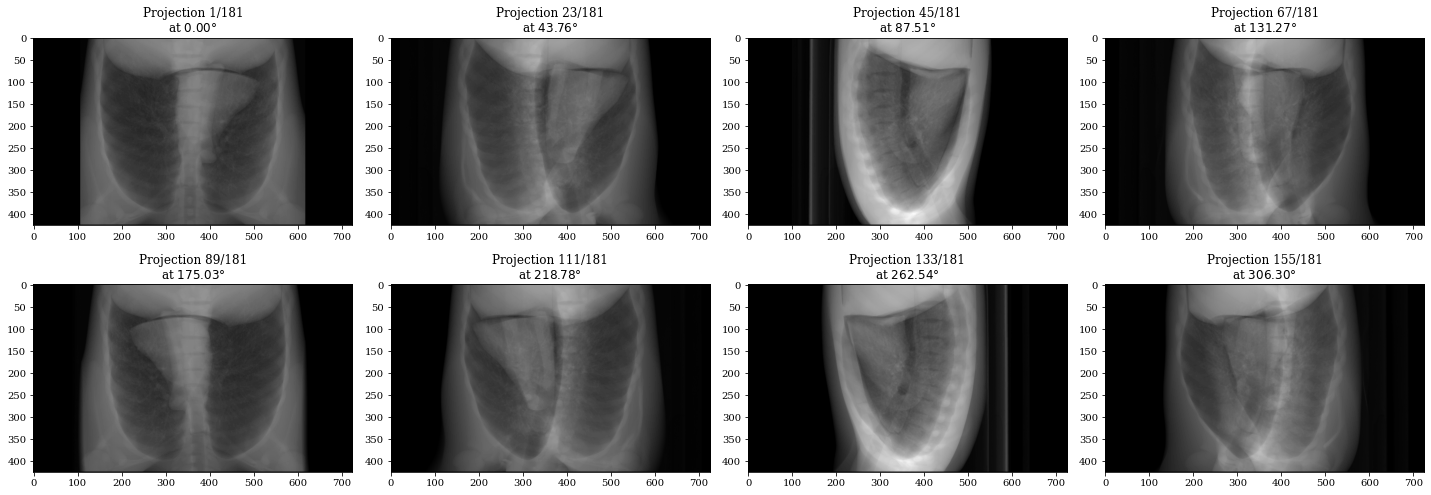

In [52]:
ncols = 4
nrows = 2

step = int(digital_phantom_proj.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(digital_phantom_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(digital_phantom_proj[slice_id], cmap='gray', vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
 
plt.tight_layout()


plt.savefig('plots/lungman-digital_phantom_proj.pdf')
plt.savefig('plots/lungman-digital_phantom_proj.png')

Draw the sinograms

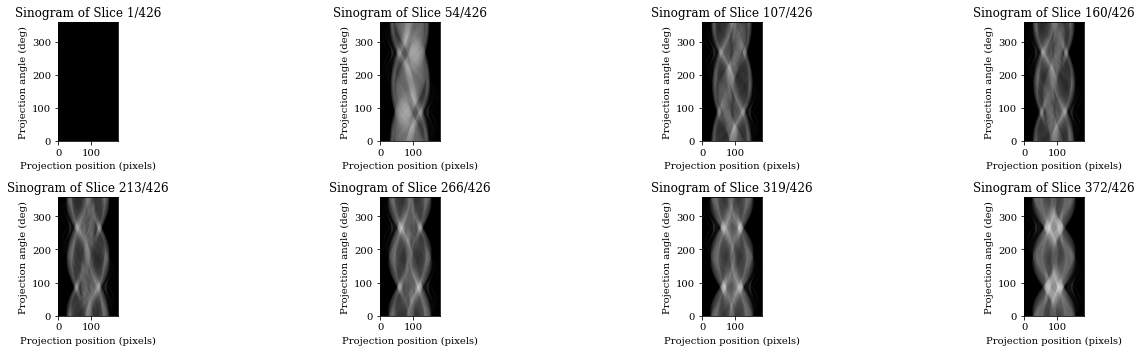

In [53]:
ncols = 4
nrows = 2

step = int(digital_phantom_sino.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_sino.shape[0]), step)

fig = plt.figure(figsize= (20, 5))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(digital_phantom_sino.shape[0]))
        ax.imshow(digital_phantom_sino[slice_id],
                  extent=[0, digital_phantom_sino.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
 
plt.tight_layout()

plt.savefig('plots/lungman-digital_phantom_sino.pdf')
plt.savefig('plots/lungman-digital_phantom_sino.png')

## CT reconstruction of the ground truth sinogram

In [56]:
fname = "gVirtualXRay_output_data/lungman-digital_phantom_CT_reconst_in_mu.mha"

if not os.path.exists(fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        digital_phantom_CT_reconst_in_mu = recons(digital_phantom_sino,
                                              theta_deg,  
                                              "parallel",
                                              "hann",
                                              real_CT_in_HU.shape[2],
                                              real_CT_in_HU.shape[1],
                                              real_CT_in_HU.shape[0],
                                              tomography_backend)
    
    # Tomopy or Tigre
    else:
        digital_phantom_CT_reconst_in_mu = recons(digital_phantom_proj,
                                          theta_deg,  
                                          "parallel", 
                                          "hann", 
                                          real_CT_in_HU.shape[2], 
                                          real_CT_in_HU.shape[1], 
                                          real_CT_in_HU.shape[0], 
                                          tomography_backend)
    
    del digital_phantom_sino # No longer needed
    
    sitk_image = sitk.GetImageFromArray(digital_phantom_CT_reconst_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * real_CT_in_HU.shape[2] / 2.0,
                          -pixel_width * real_CT_in_HU.shape[1] / 2.0,
                          -pixel_height * real_CT_in_HU.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(fname)
    digital_phantom_CT_reconst_in_mu = sitk.GetArrayFromImage(sitk_image)

# Transform to Hounsfield units
The hounsfield unit (HU) is frequently used in radiography as a means to standardise radiodensity. On the hounsfield scale, water has a HU of 0 and air -1000. Each pixel in a radiography image corresponds to the photons linear attenuation coefficient or $\mu$. The transformation for each voxel is as follows.


<center>$HU = 1000 \times \frac{\mu - \mu _{water}}{\mu _{water} - \mu _{air}}$</center>

In [57]:
def mu2HU(volume):

#     MU_air = gvxr.getMuFromHU(-1000.0, ray_energy, "keV")
#     MU_water = gvxr.getMuFromHU(0, ray_energy, "keV")

#     print(MU_air, MU_water)
    MU_air = 0
    MU_water = gvxr.getMassAttenuationFromCompound("H2O", ray_energy, "keV")
    # print(MU_air, MU_water)
    
    CT_volume_in_HU = 1000.0 * ((volume - MU_water) / (MU_water - MU_air))
    return np.array(CT_volume_in_HU).astype(np.single)        

In [59]:
fname = "gVirtualXRay_output_data/lungman-digital_phantom_CT_reconst_in_HU.mha"

# The file does not exist
if not os.path.exists(fname):

    digital_phantom_CT_reconst_in_HU = mu2HU(digital_phantom_CT_reconst_in_mu)

    sitk_image = sitk.GetImageFromArray(digital_phantom_CT_reconst_in_HU)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * digital_phantom_CT_reconst_in_HU.shape[2] / 2.0,
                          -pixel_width * digital_phantom_CT_reconst_in_HU.shape[1] / 2.0,
                          -pixel_height * digital_phantom_CT_reconst_in_HU.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(fname)
    digital_phantom_CT_reconst_in_HU = sitk.GetArrayFromImage(sitk_image)

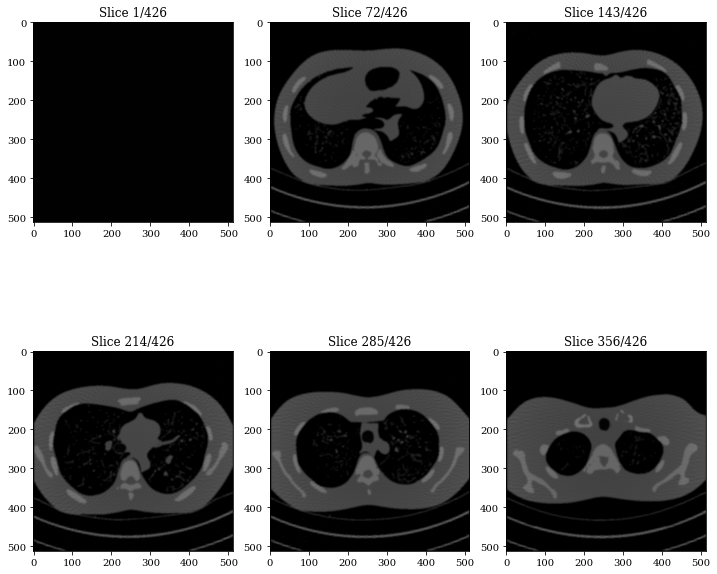

In [60]:
ncols = 3
nrows = 2

step = int(digital_phantom_CT_reconst_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_CT_reconst_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(digital_phantom_CT_reconst_in_HU.shape[0]))
        ax.imshow(digital_phantom_CT_reconst_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-digital_phantom_CT_reconst_in_HU.pdf')
plt.savefig('plots/lungman-digital_phantom_CT_reconst_in_HU.png')

**Create a phantom model from each mesh and its material.**

In [40]:
json2gvxr.initSamples("notebook-11.json", 1);

Load the 3D data

	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Loadfile_name:	lungman_data/meshes/bronchioles.stl	nb_faces:	5338192	nb_vertices:	16014576	bounding_box (in cm):	(-12.625, -8.3125, -13.65)	(11.8125, 7.3125, 12.81)
 Bronchus in lungman_data/meshes/bronchus.stl using mm
	Loadfile_name:	lungman_data/meshes/bronchus.stl	nb_faces:	701200	nb_vertices:	2103600	bounding_box (in cm):	(-11.375, -8.0625, -11.97)	(11.75, 6.5, 10.57)
 Trachea in lungman_data/meshes/trachea.stl using mm
	Loadfile_name:	lungman_data/meshes/trachea.stl	nb_faces:	88328	nb_vertices:	264984	bounding_box (in cm):	(-2.8125, -6.625, -1.68)	(3.8125, 0.5, 14.84)
 Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Skin in lungman_data/meshes/skin.stl file_name:	lungman_data/meshes/diaphram.stl	nb_faces:	507436	nb_vertices:	1522308	bounding_box (in cm):	(-12.625, -9, -14.84)	(11.875, 6.3125, -8.26)
using mm
file_name:	lungman_data/meshes/skin.stl	nb_faces:	6416748	nb_vertices:	192502

In [41]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

There are 19,277,756 triangles in total


## Visualise the virtual patient

In [ ]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    fname = sample["Path"]

    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    if label == "Skin":
        opacity = 0.2
    else:
        opacity = 1
    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity=opacity)

    plot += geometry   

plot.display()
plot.camera = [458.4242199518181, -394.5268107574361, 59.58430140683608, 93.26420522817403, -15.742963565665017, -45.88423611599179, -0.08892603121323975, 0.11140808541436767, 0.9897880578573034]

In [ ]:
fname = 'plots/lungman_model.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)
        
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

**Visualise a single projection**

0 0 500 500
0 0 512 512


(-0.5, 511.5, 511.5, -0.5)

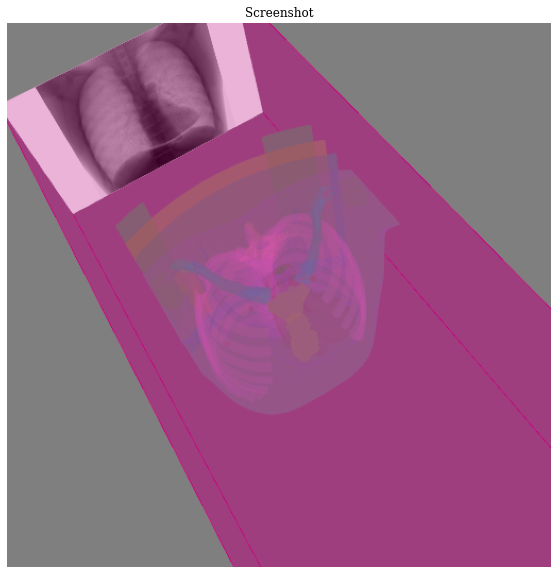

In [42]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

# Do projections

Every epoch, the scene is rotated by a step such that the number of chosen projections is reached over 180 degrees and an image is produced on the detector array. At the end a set of X-Ray images is obtained in likeness to the raw data produced by a medical scanner except sliced in a different direction.

In [43]:
%%capture

fname = "gVirtualXRay_output_data/lungman_flat.mha"
if not os.path.exists(fname):


    gvxr.disableArtefactFiltering()

    if DO_ARTEFACT_FILTERING_ON_GPU:
        gvxr.enableArtefactFilteringOnGPU()
    elif DO_ARTEFACT_FILTERING_ON_CPU:
        gvxr.enableArtefactFilteringOnCPU()

    raw_projections = [];
    angles = [];
    runtimes = []

    # Create a GIF file
    writer = None
    fname_gif = "plots/lungman_acquisition.gif"

    if not os.path.exists(fname_gif):
        writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

    rotation_axis = json2gvxr.params["Detector"]["UpVector"]

    for angle_id in range(0, number_of_projections):

        # Add the rotation angle, starting from 0
        angles.append(angle_id * angular_step)

        # Compute an X-ray image
        # xray_image = np.array(gvxr.computeXRayImage());
        start_time = datetime.datetime.now()

        xray_image = gvxr.computeXRayImage()

        # if xray_image.shape != [208, 1062]:
        #     xray_image = resize(xray_image, [208, 1062])

        # xray_image = np.array(gvxr.computeXRayImage());

        end_time = datetime.datetime.now()
        delta_time = end_time - start_time
        runtimes.append(delta_time.total_seconds() * 1000)

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])

    # We're done with the writer
    if writer is not None:
        writer.close()
        os.remove("temp.png")

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

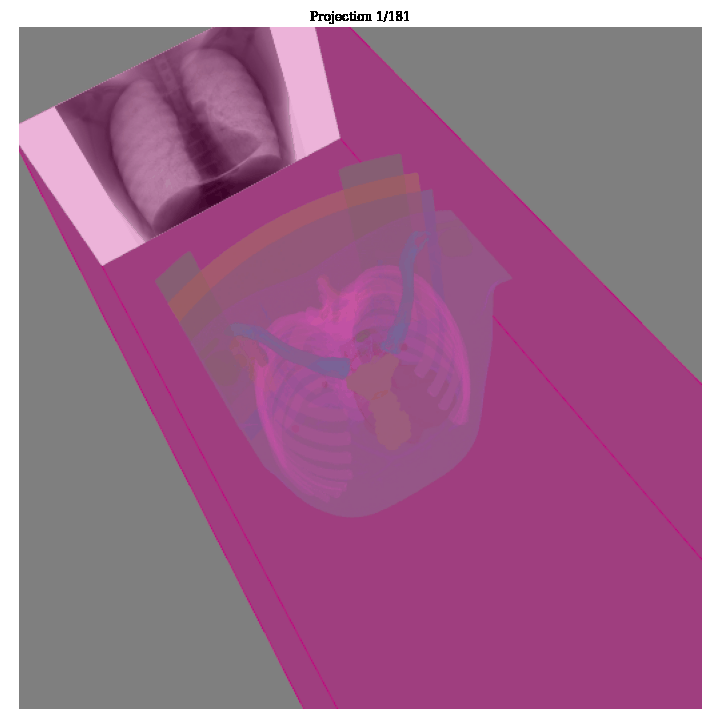

In [44]:
with open('./plots/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [45]:
if not os.path.exists(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)
    del raw_projections # Not needed anymore
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)

# Negative log normalisation

In [46]:
fname = "gVirtualXRay_output_data/lungman_minus_log_projs.mha"

if not os.path.exists(fname):

    minus_log_projs = minusLog(corrected_projections)

    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    # sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

Display the images

In [47]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

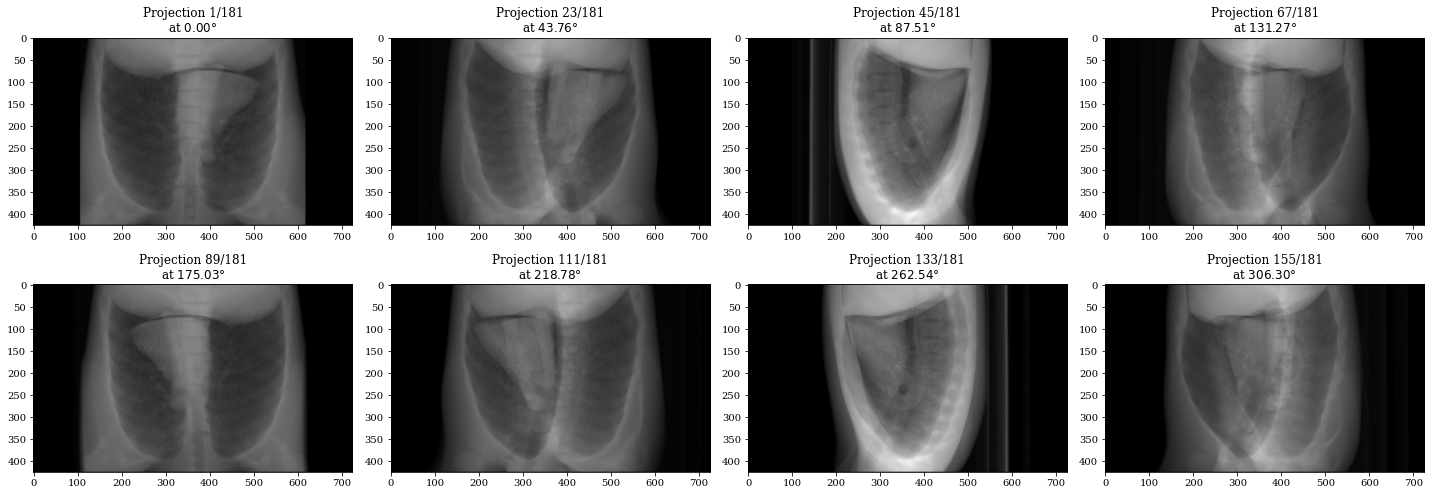

In [48]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(minus_log_projs[slice_id], cmap='gray', vmin=proj_min, vmax=proj_max)
 
plt.tight_layout()


plt.savefig('plots/lungmand-simulated-projs.pdf')
plt.savefig('plots/lungmand-simulated-projs.png')

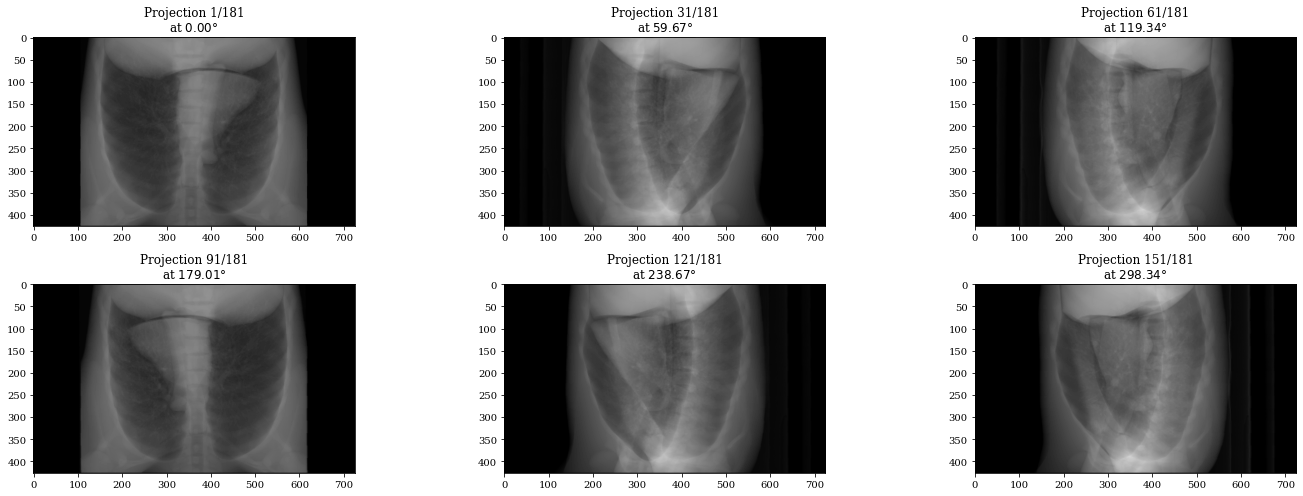

In [61]:
ncols = 3
nrows = 2

step = int(digital_phantom_proj.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(digital_phantom_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = digital_phantom_proj[slice_id]
        test_slice = minus_log_projs[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-projs.pdf')
plt.savefig('plots/lungman-compare-projs.png')

In [66]:
ZNCC_projs = np.mean((digital_phantom_proj - digital_phantom_proj.mean()) / digital_phantom_proj.std() * (minus_log_projs - minus_log_projs.mean()) / minus_log_projs.std())

# Avoid division by zero in relative error
offset1 = min(digital_phantom_proj.min(), minus_log_projs.min())
offset2 = 0.01 * (digital_phantom_proj.max() - digital_phantom_proj.min())
MAPE_projs = mape(digital_phantom_proj.flatten() - offset1 + offset2, minus_log_projs.flatten() - offset1 + offset2)

SSIM_projs = ssim(digital_phantom_proj, minus_log_projs, data_range=digital_phantom_proj.max() - digital_phantom_proj.min())

In [67]:
print("ZNCC projs:", "{0:0.2f}".format(100 * ZNCC_projs) + "%")
print("MAPE projs:", "{0:0.2f}".format(100 * MAPE_projs) + "%")
print("SSIM projs:", "{0:0.2f}".format(SSIM_projs))

ZNCC projs: 99.87%
MAPE projs: 6.15%
SSIM projs: 0.99


Save the sinograms

In [68]:
fname = "gVirtualXRay_output_data/lungman_sinograms.mha"
    
if not os.path.exists(fname):
    
    sino_shape = [
        minus_log_projs.shape[1],
        minus_log_projs.shape[0],
        minus_log_projs.shape[2]
    ]
    
    sinograms = np.zeros(sino_shape).astype(np.single)
    
    for angle_id in range(minus_log_projs.shape[0]):
        for slice_id in range(minus_log_projs.shape[1]):
            sinograms[slice_id, angle_id] = minus_log_projs[angle_id, slice_id]

    # Drop the first and last slices
    # sinograms = sinograms[1:sinograms.shape[0] - 1]
    
    # Save
    sitk_image = sitk.GetImageFromArray(sinograms)
    sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    sinograms = sitk.GetArrayFromImage(temp)

Plot some sinograms

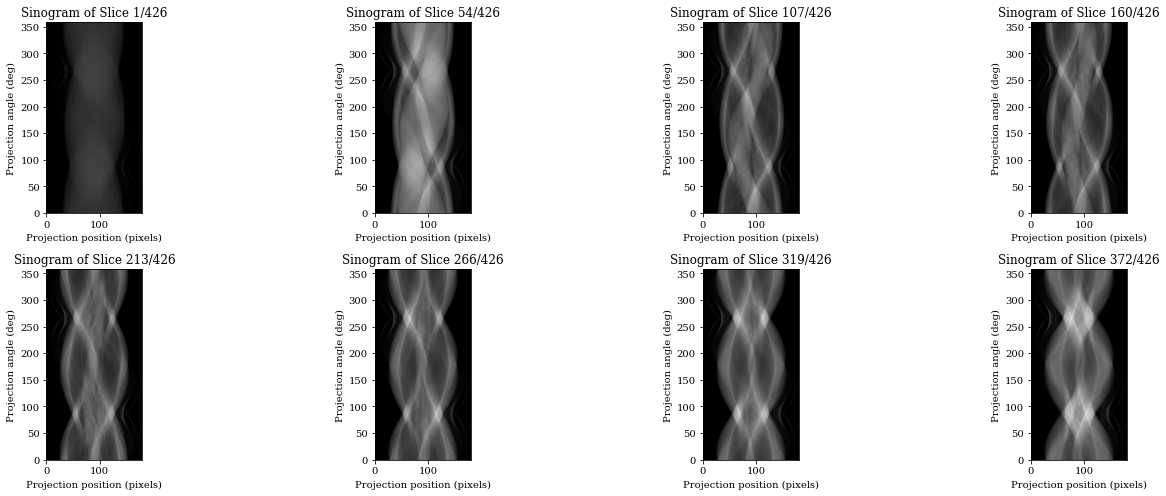

In [69]:
ncols = 4
nrows = 2

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id],
                  extent=[0, sinograms.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=proj_min, vmax=proj_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
plt.tight_layout()


plt.savefig('plots/lungman-simulated-sino.pdf')
plt.savefig('plots/lungman-simulated-sino.png')

## CT reconstruction of the simulated sinogram

In [71]:
fname = "gVirtualXRay_output_data/lungman_simu_CT_recons_in_mu.mha"

if True:# not os.path.exists(fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        
        filter_name = "ramp" # Default
        filter_name = "shepp-logan"
        filter_name = "cosine"
        filter_name = "hamming"
        filter_name = "hann"     
        
        simulated_CT_volume_in_mu = recons(sinograms,
                                  theta_deg,  
                                  "parallel",
                                  "hann",
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend)
    
    # Tomopy or Tigre
    else:
        
        # For TIGRE
        # filter_name = "ram_lak"
        filter_name = "shepp_logan"
        # filter_name = "cosine"
        # filter_name = "hamming"
        # filter_name = "hann"     
        
        
        # For Tomopy
        # filter_name = "shepp"
        # filter_name = "cosine"
        filter_name = "hann"
        # filter_name = "hamming"
        # filter_name = "ramlak"
        # filter_name = "parzen"
        # filter_name = "butterworth"
        
        simulated_CT_volume_in_mu = recons(minus_log_projs,
                                  theta_deg,  
                                  "parallel", 
                                  "hann",
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend) 
        
    sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * real_CT_in_HU.shape[2] / 2.0,
                          -pixel_width * real_CT_in_HU.shape[1] / 2.0,
                          -pixel_height * real_CT_in_HU.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

# del sinograms # Not needed anymore

# Transform to Hounsfield units

In [73]:
fname = "gVirtualXRay_output_data/lungman_simu_CT_recons_in_HU.mha"

# The file does not exist
if True:#not os.path.exists(fname):

    lungman_simu_CT_recons_in_HU = mu2HU(simulated_CT_volume_in_mu)

    sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * simulated_CT_volume_in_mu.shape[2] / 2.0,
                          -pixel_width * simulated_CT_volume_in_mu.shape[1] / 2.0,
                          -pixel_height * simulated_CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

# del CT_volume_in_mu # Not needed anymore

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

In [75]:
def compare(ref_image, test_image):

    ZNCC = np.mean((ref_image - ref_image.mean()) / ref_image.std() * (test_image - test_image.mean()) / test_image.std())
    print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

    offset1 = min(ref_image.min(), test_image.min())
    offset2 = 0.1 * (ref_image.max() - ref_image.min())
    MAPE = mape(ref_image.flatten() - offset1 + offset2, test_image.flatten() - offset1 + offset2)
    print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")

    SSIM = ssim(ref_image, test_image, data_range=ref_image.max() - ref_image.min())
    print("SSIM:", "{0:0.2f}".format(SSIM))
    
    return ZNCC, MAPE, SSIM

## real CT vs digital phantom HU

In [76]:
compare(real_CT_in_HU, digital_phatom_in_HU);

ZNCC: 97.50%
MAPE: 7.93%
SSIM: 0.86


(0.9750471529083302, 0.07926124, 0.8592777042246829)

## real CT vs digital phantom mu

In [78]:
compare(real_CT_in_mu, digital_phatom_in_mu);

ZNCC: 83.73%
MAPE: 1.27%
SSIM: 0.98


## real CT vs recons of digital phantom HU

In [80]:
compare(real_CT_in_HU, digital_phantom_CT_reconst_in_HU);

ZNCC: 95.10%
MAPE: 9.60%
SSIM: 0.44


## real CT vs recons of digital phantom mu

In [81]:
compare(digital_phatom_in_mu, digital_phantom_CT_reconst_in_mu);

ZNCC: 95.52%
MAPE: 10.55%
SSIM: 0.23


## digital phantom vs recons of digital phantom HU

In [ ]:
compare(digital_phatom_in_HU, digital_phantom_CT_reconst_in_HU);

ZNCC: 95.54%
MAPE: 10.60%


## digital phantom vs recons of digital phantom HU

In [ ]:
compare(digital_phatom_in_mu, digital_phantom_CT_reconst_in_mu);

## Real CT vs recons of simu projs HU

In [ ]:
compare(real_CT_in_HU, lungman_simu_CT_recons_in_HU);

## Real CT vs recons of simu projs mu

In [ ]:
compare(real_CT_in_mu, lungman_simu_CT_recons_in_mu);

## digital phantom  vs recons of simu projs HU

In [ ]:
compare(digital_phatom_in_HU, lungman_simu_CT_recons_in_HU);

## digital phantom vs recons of simu projs mu

In [ ]:
compare(digital_phatom_in_mu, lungman_simu_CT_recons_in_mu);

## recons of digital phantom vs recons of simu projs HU

In [ ]:
compare(digital_phantom_CT_reconst_in_HU, lungman_simu_CT_recons_in_HU);

## recons of digital phantom  vs recons of simu projs mu

In [ ]:
compare(digital_phantom_CT_reconst_in_mu, lungman_simu_CT_recons_in_mu);

In [ ]:
real_CT_diag = np.diag(real_CT_in_HU)
digital_phatom_diag = np.diag(digital_phatom_in_HU)
digital_phantom_CT_reconst_diag = np.diag(digital_phantom_CT_reconst_in_HU)
lungman_simu_CT_recons_diag = np.diag(lungman_simu_CT_recons_in_HU)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(real_CT_diag, label="Middle slice of real CT")
ax.plot(digital_phatom_diag, label="Middle slice of digital phantom")
ax.plot(digital_phantom_CT_reconst_diag, label="Middle slice of volume reconstructed from\nprojections of digital phantom")
ax.plot(lungman_simu_CT_recons_diag, label="Middle slice of volume reconstructed from\nprojections simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

In [ ]:
real_CT_diag = np.diag(real_CT_in_mu)
digital_phatom_diag = np.diag(digital_phatom_in_mu)
digital_phantom_CT_reconst_diag = np.diag(digital_phantom_CT_reconst_in_mu)
lungman_simu_CT_recons_diag = np.diag(lungman_simu_CT_recons_in_mu)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(real_CT_diag, label="Middle slice of real CT")
ax.plot(digital_phatom_diag, label="Middle slice of digital phantom")
ax.plot(digital_phantom_CT_reconst_diag, label="Middle slice of volume reconstructed from\nprojections of digital phantom")
ax.plot(lungman_simu_CT_recons_diag, label="Middle slice of volume reconstructed from\nprojections simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

In [ ]:
fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/digimouse-compare-CT",
                  False,
                 ref_slice.min(), ref_slice.max())

In [ ]:
comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(25, 25))

fig = plt.figure(figsize=(15, 10))

ncols = 3
nrows = 1

ax = fig.add_subplot(nrows, ncols, 1)
ax.set_title("Middle slice of volume reconstructed from\nphantom sinogram")
ax.imshow(ref_slice, cmap="gray", vmin=0, vmax=ref_slice.max())

ax = fig.add_subplot(nrows, ncols, 2)
ax.set_title("Middle slice of volume reconstructed from\nprojections simulated using gVirtualXRay")
ax.imshow(test_slice, cmap="gray", vmin=0, vmax=ref_slice.max())

ax = fig.add_subplot(nrows, ncols, 3)
ax.set_title("Checkerboard comparison")
ax.imshow(comp_equalized, cmap="gray", vmin=0, vmax=ref_slice.max())


plt.tight_layout()

plt.savefig('plots/digimouse-checkerboard-CT.pdf')
plt.savefig('plots/digimouse-checkerboard-CT.png')

In [ ]:
fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/digimouse-compare-alternative-CT",
                  False,
                 ref_slice.min(), ref_slice.max())

### simulated projections vs ground truth sinograms

In [ ]:
ZNCC_sinogram = np.mean((ground_truth_proj - ground_truth_proj.mean()) / ground_truth_proj.std() * (minus_log_projs - minus_log_projs.mean()) / minus_log_projs.std())
SSIM_sinogram = ssim(ground_truth_proj, minus_log_projs, data_range=ground_truth_proj.max() - ground_truth_proj.min())

print("ZNCC full sino:", "{0:0.2f}".format(100 * ZNCC_sinogram) + "%")
print("SSIM full sino:", "{0:0.2f}".format(SSIM_sinogram))

The X-ray projections simulated with gVirtualXRay are perfectly correlated with the DRRs computed using the Radon transform of the phantom (ZNCC is 100.00%, SSIM is 1.00).

In [ ]:
ref_slice = ground_truth_proj[ground_truth_proj.shape[0] // 2]
test_slice = minus_log_projs[minus_log_projs.shape[0] // 2]

In [ ]:
ZNCC_slice = np.mean((ref_slice - ref_slice.mean()) / ref_slice.std() * (test_slice - test_slice.mean()) / test_slice.std())
SSIM_slice = ssim(ref_slice, test_slice, data_range=ref_slice.max() - ref_slice.min())

print("ZNCC proj:", "{0:0.2f}".format(100 * ZNCC_slice) + "%")
print("SSIM proj:", "{0:0.2f}".format(SSIM_slice))

In [ ]:
comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(25, 25))

fig = plt.figure(figsize=(20, 10))

ncols = 3
nrows = 1

ax = fig.add_subplot(nrows, ncols, 1)
ax.set_title("DRR from phantom")
ax.imshow(ref_slice, cmap="gray", vmin=0, vmax=ref_slice.max())

ax = fig.add_subplot(nrows, ncols, 2)
ax.set_title("Corresponding projection simulated using gVirtualXRay")
ax.imshow(test_slice, cmap="gray", vmin=0, vmax=ref_slice.max())

ax = fig.add_subplot(nrows, ncols, 3)
ax.set_title("Checkerboard comparison")
ax.imshow(comp_equalized, cmap="gray", vmin=0, vmax=ref_slice.max())

plt.tight_layout()


plt.savefig('plots/digimouse-checkerboard-proj.pdf')
plt.savefig('plots/digimouse-checkerboard-proj.png')

In [ ]:
fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/digimouse-compare-projs",
                  False,
                 ref_slice.min(), ref_slice.max())

In [ ]:
ref_diag = np.diag(ref_slice)
test_diag = np.diag(test_slice)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

Print a row of the table for the paper

In [ ]:
print("Digimouse CT acquisition & Synthetic volume & " + 
      "N/A    &    " +
      "{0:0.2f}".format(100 * ZNCC_sinogram) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_sinogram) + "    &    $" +
      str(ground_truth_proj.shape[2]) + " \\times " + str(ground_truth_proj.shape[1]) + " \\times " + str(ground_truth_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
print("Digimouse CT reconstruction & Synthetic volume & " + 
      "N/A    &    " +
      "{0:0.2f}".format(100 * ZNCC_CT) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_CT) + "    &    $" +
      str(ground_truth_proj.shape[2]) + " \\times " + str(ground_truth_proj.shape[1]) + " \\times " + str(ground_truth_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
del ground_truth_proj # Not needed anymore
del minus_log_projs # Not needed anymore

Shutdown the simulation

In [ ]:
print(sinograms.shape)
print(minus_log_projs.shape)
print(CT_volume_in_HU.shape)
print(CT_volume_in_mu.shape)
print(ground_truth_CT_recons_in_HU.shape)
print(ground_truth_CT_recons_in_mu.shape)
print(ground_truth2_CT_recons_in_HU.shape)
print(ground_truth2_CT_recons_in_mu.shape)


## Display the CT slices

In [ ]:
ncols = 3
nrows = 2

step = int(CT_volume_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume_in_HU.shape[0]))
        ax.imshow(CT_volume_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-simulated-CT.pdf')
plt.savefig('plots/lungman-simulated-CT.png')

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

### Ground truth CT reconstruction vs CT reconstructed from simulated projections

In [ ]:
ref_volume = np.copy(ground_truth2_CT_recons_in_HU)
# ref_volume = np.copy(ground_truth_CT_recons_in_mu)

test_volume = np.copy(CT_volume_in_HU)
# test_volume = np.copy(CT_volume_in_mu)

# Drop the first and last slices
ref_volume = ref_volume[1:ref_volume.shape[0] - 1]
test_volume = test_volume[1:test_volume.shape[0] - 1]

ZNCC_CT = np.mean((ref_volume - ref_volume.mean()) / ref_volume.std() * (test_volume - test_volume.mean()) / test_volume.std())

# Avoid division by zero in relative error
offset1 = min(ref_volume.min(), test_volume.min())
offset2 = 0.01 * (ref_volume.max() - ref_volume.min())
MAPE_CT = mape(ref_volume.flatten() - offset1 + offset2, test_volume.flatten() - offset1 + offset2)

# SSIM_CT = ssim(ref_volume, test_volume, data_range=ref_volume.max() - ref_volume.min())

In [ ]:
print("ZNCC CT:", "{0:0.2f}".format(100 * ZNCC_CT) + "%")
print("MAPE CT:", "{0:0.2f}".format(100 * MAPE_CT) + "%")
# print("SSIM CT:", "{0:0.2f}".format(np.mean(SSIM_CT)))
# print("SSIM CT:", "{0:0.2f}".format(SSIM_CT))

Tigre

shepp
ZNCC CT: 96.75%
MAPE CT: 17.01%

cosine
ZNCC CT: 97.44%
MAPE CT: 38.08%

Tomopy

shepp
ZNCC CT: 95.06%
MAPE CT: 11.03%

cosine
ZNCC CT: 96.19%
MAPE CT: 13.05%

hann
ZNCC CT: 96.09%
MAPE CT: 14.08%

hamming
ZNCC CT: 96.09%
MAPE CT: 13.72%

ramlak
ZNCC CT: 94.14%
MAPE CT: 10.36%

parzen
ZNCC CT: 96.84%
MAPE CT: 20.66%

butterworth
ZNCC CT: 94.43%
MAPE CT: 10.38%



In [ ]:
ref_slice = np.copy(ref_volume[ref_volume.shape[0] // 2]).astype(np.single)
test_slice = np.copy(test_volume[test_volume.shape[0] // 2]).astype(np.single)

In [ ]:
ZNCC_slice = np.mean((ref_slice - ref_slice.mean()) / ref_slice.std() * (test_slice - test_slice.mean()) / test_slice.std())

offset1 = min(ref_slice.min(), test_slice.min())
offset2 = 0.01 * (ref_slice.max() - ref_slice.min())
MAPE_slice = mape(ref_slice - offset1 + offset2, test_slice - offset1 + offset2)
# MAPE_slice = mape(ref_slice, test_slice)
SSIM_slice = ssim(ref_slice, test_slice, data_range=ref_slice.max() - ref_slice.min())

print("ZNCC slice:", "{0:0.2f}".format(100 * ZNCC_slice) + "%")
print("MAPE slice:", "{0:0.2f}".format(100 * MAPE_slice) + "%")
print("SSIM slice:", "{0:0.2f}".format(SSIM_slice))

Tigre

cosine
ZNCC slice: 97.19%
MAPE slice: 42.52%
SSIM slice: 0.18

shepp
ZNCC slice: 96.38%
MAPE slice: 32.72%
SSIM slice: 0.55



Tomopy

cosine
ZNCC slice: 95.69%
MAPE slice: 14.96%
SSIM slice: 0.37

shepp
ZNCC slice: 94.40%
MAPE slice: 14.87%
SSIM slice: 0.28

hann
ZNCC slice: 95.59%
MAPE slice: 16.78%
SSIM slice: 0.37

hamming
ZNCC slice: 95.60%
MAPE slice: 16.61%
SSIM slice: 0.37

ramlak
ZNCC slice: 93.36%
MAPE slice: 14.48%
SSIM slice: 0.24

parzen
ZNCC slice: 96.45%
MAPE slice: 23.03%
SSIM slice: 0.56

butterworth
ZNCC slice: 93.69%
MAPE slice: 14.22%
SSIM slice: 0.25

In [ ]:
ref_diag = np.diag(ref_slice)
test_diag = np.diag(test_slice)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="Middle slice of Ground truth")
ax.plot(test_diag, label="Middle slice of volume reconstructed from\nprojections simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

plt.savefig('plots/lungman-profiles-CT.pdf')
plt.savefig('plots/lungman-profiles-CT.png')

In [ ]:
# Avoid division by zero in relative error
offset1 = min(ref_slice.min(), test_slice.min())
offset2 = 0.01 * (ref_slice.max() - ref_slice.min())

# ref_slice += offset2 - offset1
# test_slice += offset2 - offset1

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-CT",
                  False,
                  ref_slice.min(), ref_slice.max())

In [ ]:
ncols = 3
nrows = 2

step = int(ref_volume.shape[0] / (ncols * nrows))
slices = range(0, int(ref_volume.shape[0]), step)

fig = plt.figure(figsize= (10,10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(ref_volume.shape[0]))
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = ref_volume[slice_id]
        test_slice = test_volume[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-CT.pdf')
plt.savefig('plots/lungman-compare-CT.png')

The CT volumes reconstructed from ground truth sinograms and simulated sinograms exhibit the same metrics when compared to the phantom (ZNCC is 99.30% 99.25%, SSIM is 0.66 and 0.63).

In [ ]:
runtimes_mean = round(np.mean(runtimes));
runtimes_std = round(np.std(runtimes));
print(" Lungman - CT acquisition & Real CT of Lungman phantom & " + "{0:0.2f}".format(100 * MAPE_CT) + "\\%" +
      "    &    " +
      "{0:0.2f}".format(100 * ZNCC_CT) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_CT) + "    &    $" +
      str(ground_truth_CT_recons_in_HU.shape[2]) + " \\times " + str(ground_truth_CT_recons_in_HU.shape[1]) + " \\times " + str(ground_truth_CT_recons_in_HU.shape[0]) + "$    &    " +
      f"{number_of_triangles:,}" + "    &    " + "N/A  &  " +
      "$" + str(runtimes_mean) + " \\pm " + str(runtimes_std) + "$ \\\\")

## Check Hounsfield Units for all the structures

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

offset1 = min(ground_truth_CT_recons_in_HU.min(), CT_volume_in_HU.min())
offset2 = 0.01 * (ground_truth_CT_recons_in_HU.max() - ground_truth_CT_recons_in_HU.min())
ground_truth_CT_recons_in_HU_corrected = ground_truth_CT_recons_in_HU - offset1 + offset2
CT_volume_in_HU_corrected = CT_volume_in_HU - offset1 + offset2


acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
print("Name\t\tReference HU\tSimulated HU\tMean absolute Error\tMean relative Error (in %)");
while ( i < len(split_lines)):
   
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Drop the first and last slices
    mask = mask[1:mask.shape[0] - 1]

    # Apply mask to simulated CT
    simulated_masked = CT_volume_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    ground_masked = ground_truth_CT_recons_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    # abs_diff = np.mean(np.abs(simulated_masked - ground_masked))
    # avg_rel_diff = np.mean(np.abs((simulated_masked - ground_masked) / ground_masked)) * 100
    
    avg_simulated_HU = np.mean(simulated_masked);
    # avg_ground_HU = float(tuple_parts[1]);
    avg_ground_HU = np.mean(ground_masked);
    
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);

#     ground_corrected_masked = ground_truth_CT_recons_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
#     simulated_corrected_masked = CT_volume_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)

#     diff = ground_corrected_masked - simulated_corrected_masked
#     abs_diff = np.mean(np.abs(diff))
#     avg_rel_diff = 100 * np.mean(np.abs(diff / ground_corrected_masked))
    format = "{structure:<15}\t{ref:<15.3f}\t{sim:<15.3f}\t{abs:.3f}\t{rel:<15.3f}";
    print(format.format(structure=name, ref=avg_ground_HU, sim=avg_simulated_HU, rel=avg_rel_diff, abs=abs_diff));
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

offset1 = min(ground_truth_CT_recons_in_HU.min(), CT_volume_in_HU.min())
offset2 = 0.01 * (ground_truth_CT_recons_in_HU.max() - ground_truth_CT_recons_in_HU.min())
ground_truth_CT_recons_in_HU_corrected = ground_truth_CT_recons_in_HU - offset1 + offset2
CT_volume_in_HU_corrected = CT_volume_in_HU - offset1 + offset2


acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
cols=["Name","Mean reference HU","Stddev reference HU", "Mean simulated HU", "Stddev simulated HU", "Relative Error (in %)", "Absolute Error"]
data = []
print("Name\t\tReference HU\tSimulated HU\tRelative Error (in %)\tAbsolute Error");
while ( i < len(split_lines)):
    row = []
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Drop the first and last slices
    mask = mask[1:mask.shape[0] - 1]

    # Apply mask to simulated CT
    simulated_masked = CT_volume_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    ground_masked = ground_truth_CT_recons_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    # abs_diff = np.mean(np.abs(simulated_masked - ground_masked))
    # avg_rel_diff = np.mean(np.abs((simulated_masked - ground_masked) / ground_masked)) * 100
    
    avg_simulated_HU = np.mean(simulated_masked);
    stddev_simulated_HU = np.std(simulated_masked);
    # avg_ground_HU = float(tuple_parts[1]);
    avg_ground_HU = np.mean(ground_masked);
    stddev_ground_HU = np.std(ground_masked);
    
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);

#     ground_corrected_masked = ground_truth_CT_recons_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
#     simulated_corrected_masked = CT_volume_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)

#     diff = ground_corrected_masked - simulated_corrected_masked
#     abs_diff = np.mean(np.abs(diff))
#     avg_rel_diff = 100 * np.mean(np.abs(diff / ground_corrected_masked))


    format = "{structure:<15}\t{ref:<15.3f}\t{sim:<15.3f}\t{rel:<15.3f}\t\t{abs:.3f}";
    print(format.format(structure=name, ref=avg_ground_HU, sim=avg_simulated_HU, rel=avg_rel_diff, abs=abs_diff));
    row.append(name)
    row.append(avg_ground_HU)
    row.append(stddev_ground_HU)
    row.append(avg_simulated_HU)
    row.append(stddev_simulated_HU)
    row.append(avg_rel_diff)
    row.append(abs_diff)
    
    data.append(row)
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));

In [ ]:
df_HU = pd.DataFrame(data=data, columns=cols)
df_HU.to_csv("gVirtualXRay_output_data/lungman-HU.csv")